In [2]:
from collections import Counter
from collections import defaultdict
import itertools
import math
import os

import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyperclip
from gensim.corpora import Dictionary
from gensim.models import Word2Vec

In [3]:
# Seaborn globals
sns.set(rc={'figure.figsize':(10,6)})
sns.set_theme(style="whitegrid")

# Path globals
fig_path = "../figs/"

### Global Functions

In [4]:
def get_embedding_df(w2v_model):
    w2v_rows = []
    for cur_kw in keywords:
        if cur_kw not in w2v_model.wv:
            continue
        cur_vec = w2v_model.wv[cur_kw]
        cur_row = [cur_kw] + list(cur_vec)
        w2v_rows.append(cur_row)
    w2v_df = pd.DataFrame(w2v_rows, columns=['token','x','y'])
    return w2v_df

def label_points(x, y, val, ax, x_offset=0.015, adjustments=None):
    label_df = pd.concat({'x': x, 'y': y, 'label': val}, axis=1)
    if adjustments:
        # And adjust the vals accordingly
        label_df.set_index('label', inplace=True)
        for adj_word, adj_shift in adjustments.items():
            if adj_word in label_df.index:
                label_df.loc[adj_word] = label_df.loc[adj_word] + adj_shift
        label_df.reset_index(inplace=True)
    for i, point in label_df.iterrows():
        ax.text(point['x']+x_offset, point['y'], str(point['label']), va='center', fontdict={'size':13})

def copy_colab_str(word_vecs):
    colab_str = str([[ti for ti in t] for t in word_vecs.values])
    pyperclip.copy(colab_str)

### Global Variables

In [5]:
#global_window = 21
global_window = 11
global_epochs = 50

### Define keywords

In [6]:
keywords = [
    #'covenant',
    #'god',
    'authority',
    'christ',
    'civill',
    'common-wealth',
    #'duty',
    #'externall',
    'externall_impediment',
    'fear',
    'free',
    'government',
    'holy',
    #'impediment',
    #'internall',
    #'judge',
    'justice',
    'king',
    'kingdome',
    'law',
    'liberty',
    'lord',
    #'man',
    'obey',
    'power',
    #'reason',
    'soveraign',
    #'subject'
    #'supreme',
    #'obligation',
    #'right',
    #'nature',
]

join_tokens = [
    ('externall','impediment'),
]

token_clusters = [
    ['christ','jesus'],
    ['externall','external'],
    ['fear','feare','feared','fears','fearing','feares','fearfull','feareth','feare—'],
    ['free','freely','freedome','free-will','freewill'],
    ['god','gods'],
    ['impediment','impediments'],
    ['internall','internal'],
    ['king','kings'],
    ['law','laws','lawes'],
    ['liberty', 'libertie', 'libertatis', 'libertas'],
    ['man','men'],
    ['obey', 'obedience'],
    ['soveraign','soveraignty','soveraigne'],
    ['subject','subjects'],
]
cluster_map = {}
for cur_cluster in token_clusters:
    cluster_main = cur_cluster[0]
    for cur_token in cur_cluster:
        cluster_map[cur_token] = cluster_main
kw_pairs = list(itertools.combinations_with_replacement(keywords, 2))
#kw_pairs

### Load Texts

In [7]:
text_path = os.path.join("..","corpus_hobbes")
default_texts = ['behemoth', 'de_cive', 'elements', 'leviathan']
def load_texts(text_list=default_texts):
    raw_texts = []
    for text_name in text_list:
        fname = f"{text_name}.txt"
        fpath = os.path.join(text_path, fname)
        with open(fpath, 'r', encoding='utf-8') as infile:
            cur_text = infile.read()
            raw_texts.append(cur_text)
    raw_text = "\n\n\n".join(raw_texts)
    return raw_text

In [8]:
text = load_texts()

In [9]:
clean_text = text.lower()

In [10]:
def preprocess_tokens(token_list):
    punct_list = ".,\"':!?;()“”’&[]1234567890"
    def remove_punct(token):
        return "".join([t for t in token if t not in punct_list])
    clean_tokens = [remove_punct(t) for t in token_list]
    en_stopwords = nltk.corpus.stopwords.words('english')
    clean_tokens = [t for t in clean_tokens if t not in en_stopwords]

    #cluster_map
    def collapse_token(orig_token):
        return cluster_map[orig_token] if orig_token in cluster_map else orig_token
    clean_tokens = [collapse_token(t) for t in clean_tokens]
    # Join phrases
    for token_index in range(len(clean_tokens)-1):
        cur_token = clean_tokens[token_index]
        next_token = clean_tokens[token_index+1]
        token_tuple = (cur_token, next_token)
        if cur_token == "externall" or next_token == "externall":
            print(cur_token, next_token)
        if (cur_token, next_token) in join_tokens:
            print(f"Joining {token_tuple}")
            clean_tokens[token_index] = cur_token + "_" + next_token
            clean_tokens[token_index+1] = ""
    # Lastly, remove any blank tokens
    clean_tokens = [t for t in clean_tokens if len(t) > 0]
    return clean_tokens

## Method 1: Tokenize words (ignoring sentence structure)

In [11]:
tokens = clean_text.split()

In [12]:
clean_tokens = preprocess_tokens(tokens)

alwayes externall
externall court
belongs externall
externall obey
promise externall
externall signes
lets externall
externall absolute
produced externall
externall agent
profession externall
externall say
internall externall
externall rest
action externall
externall objects
already externall
externall objects
jews externall
externall performance
religion externall
externall worship
operatum externall
externall action
internall externall
externall righteousness
sense externall
externall body
motion externall
externall things
receive externall
externall bodies
action externall
externall objects
action externall
externall objects
helps externall
externall women
reall externall
externall substances
absence externall
externall impediment
Joining ('externall', 'impediment')
mean externall
externall impediment
Joining ('externall', 'impediment')
opposition externall
externall body
without externall
externall impediment
Joining ('externall', 'impediment')
appetite externall
externall accident

In [13]:
clean_tokens

['dialogue',
 'time',
 'place',
 'degrees',
 'high',
 'low',
 'verily',
 'believe',
 'highest',
 'time',
 'would',
 'passed',
 'years',
 'thence',
 'devils',
 'mountain',
 'looked',
 'upon',
 'world',
 'observed',
 'actions',
 'man',
 'especially',
 'england',
 'might',
 'prospect',
 'kinds',
 'injustice',
 'kinds',
 'folly',
 'world',
 'could',
 'afford',
 'produced',
 'dams',
 'hypocrisy',
 'self-conceit',
 'whereof',
 'one',
 'double',
 'iniquity',
 'double',
 'folly',
 'glad',
 'behold',
 'prospect',
 'lived',
 'time',
 'part',
 'age',
 'wherein',
 'man',
 'used',
 'see',
 'best',
 'good',
 'evil',
 'pray',
 'set',
 'could',
 'see',
 'well',
 'upon',
 'mountain',
 'relation',
 'actions',
 'saw',
 'causes',
 'pretensions',
 'justice',
 'order',
 'artifice',
 'event',
 'year',
 'government',
 'england',
 'monarchical',
 'king',
 'reigned',
 'charles',
 'first',
 'name',
 'holding',
 'sovereignty',
 'right',
 'descent',
 'continued',
 'six',
 'hundred',
 'years',
 'much',
 'longer',
 

### Now we can compute token counts

In [14]:
token_counts = Counter(clean_tokens)
token_counts_sorted = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)

In [15]:
token_counts_nonunique = [t for t in token_counts_sorted if t[1] > 20]

In [16]:
len(token_counts_nonunique)

1575

In [17]:
token_counts_nonunique[-1000:]

[('v', 62),
 ('observed', 61),
 ('especially', 61),
 ('help', 61),
 ('lay', 61),
 ('allowed', 61),
 ('articles', 61),
 ('works', 61),
 ('forbidden', 61),
 ('please', 61),
 ('shew', 61),
 ('mutuall', 61),
 ('shewed', 61),
 ('moyses', 61),
 ('clergy', 60),
 ('gift', 60),
 ('charge', 60),
 ('sedition', 60),
 ('country', 60),
 ('proceeding', 60),
 ('signs', 60),
 ('signifieth', 60),
 ('tell', 59),
 ('born', 59),
 ('fall', 59),
 ('commission', 59),
 ('preaching', 59),
 ('foundation', 59),
 ('went', 59),
 ('coming', 59),
 ('gotten', 59),
 ('sign', 59),
 ('alwayes', 59),
 ('supernaturall', 59),
 ('proceedeth', 59),
 ('sufficiently', 58),
 ('masters', 58),
 ('heathen', 58),
 ('alone', 58),
 ('powers', 58),
 ('following', 58),
 ('extraordinary', 58),
 ('lawfully', 58),
 ('matters', 58),
 ('creatures', 58),
 ('morall', 58),
 ('followes', 58),
 ('elders', 58),
 ('agree', 57),
 ('wise', 57),
 ('language', 57),
 ('twelve', 57),
 ('dreams', 57),
 ('vision', 57),
 ('sort', 56),
 ('held', 56),
 ('pecu

In [18]:
all_tokens = [t[0] for t in token_counts_nonunique]

In [19]:
all_tokens

['man',
 'law',
 'god',
 'one',
 'power',
 'therefore',
 'king',
 'may',
 'also',
 'hath',
 'right',
 'shall',
 'nature',
 'every',
 'subject',
 'say',
 'another',
 'people',
 'yet',
 'time',
 'upon',
 'christ',
 'things',
 'soveraign',
 'without',
 'made',
 'first',
 'called',
 'reason',
 'authority',
 'make',
 'onely',
 'many',
 'obey',
 'though',
 'good',
 'thing',
 'civill',
 'words',
 'cannot',
 'place',
 'either',
 'done',
 'must',
 'said',
 'great',
 'would',
 'parliament',
 'doe',
 'part',
 'much',
 'word',
 'church',
 'nothing',
 'government',
 'common-wealth',
 'kingdome',
 'naturall',
 'others',
 'unto',
 'us',
 'peace',
 'like',
 'fear',
 'city',
 'himselfe',
 'come',
 'actions',
 'two',
 'name',
 'life',
 'use',
 'person',
 'could',
 'faith',
 'covenant',
 'command',
 'body',
 'take',
 'think',
 'know',
 'manner',
 'necessary',
 'concerning',
 'give',
 'lord',
 'world',
 'neither',
 'christian',
 'whether',
 'might',
 'liberty',
 'true',
 'well',
 'taken',
 'cause',
 'cont

In [20]:
num_tokens = len(all_tokens)
num_tokens

1575

And now assign numbers to each token

In [21]:
token_dict = Dictionary([clean_tokens])

In [22]:
#token_dict.most_common()
token_dict.token2id

{'*arise': 0,
 '-': 1,
 'aaron': 2,
 'aarons': 3,
 'abandon': 4,
 'abandoned': 5,
 'abandoning': 6,
 'abandons': 7,
 'abased': 8,
 'abate': 9,
 'abatement': 10,
 'abating': 11,
 'abaton': 12,
 'abbadon': 13,
 'abbeys': 14,
 'abdera': 15,
 'abdias': 16,
 'abdication': 17,
 'aberdeen': 18,
 'abettors': 19,
 'abhor': 20,
 'abhorre': 21,
 'abhorreth': 22,
 'abiathar': 23,
 'abide': 24,
 'abides': 25,
 'abideth': 26,
 'abihu': 27,
 'abilities': 28,
 'ability': 29,
 'abilityes': 30,
 'abimelech': 31,
 'abiram': 32,
 'abirom': 33,
 'abishai': 34,
 'abjuration': 35,
 'able': 36,
 'abler': 37,
 'ablest': 38,
 'abner': 39,
 'aboad': 40,
 'abode': 41,
 'abolish': 42,
 'abolished': 43,
 'abolishing': 44,
 'abolisht': 45,
 'abolition': 46,
 'abominable': 47,
 'abomination': 48,
 'abound': 49,
 'aboundance': 50,
 'above-named': 51,
 'abraham': 52,
 'abrahams': 53,
 'abridge': 54,
 'abridged': 55,
 'abroad': 56,
 'abrogate': 57,
 'abrogated': 58,
 'abrogating': 59,
 'abrogation': 60,
 'absence': 61,


### Define Keywords

In [23]:
#token_pairs = list(itertools.product(all_tokens,all_tokens))
#len(token_pairs)

In [24]:
#kw_pairs = [pair for pair in list(itertools.product(keywords,keywords)) if pair[0] != pair[1]]
kw_pairs = list(itertools.product(keywords,keywords))
kw_pairs[:10]

[('authority', 'authority'),
 ('authority', 'christ'),
 ('authority', 'civill'),
 ('authority', 'common-wealth'),
 ('authority', 'externall_impediment'),
 ('authority', 'fear'),
 ('authority', 'free'),
 ('authority', 'government'),
 ('authority', 'holy'),
 ('authority', 'justice')]

### And ngrams

In [25]:
def compute_ngrams(input_list, n):
    return zip(*[input_list[i:] for i in range(n)])

In [26]:
N = 4

In [27]:
all_ngrams = list([set(ng) for ng in compute_ngrams(clean_tokens, N)])
len(all_ngrams)

197827

In [28]:
from tqdm import tqdm

In [29]:
token_pair_counts = defaultdict(lambda: 0)

In [30]:
keywords_co = defaultdict(lambda: 0)
for cur_ngram in tqdm(all_ngrams):
    ngram_pairs = list(itertools.combinations(cur_ngram, r=2))
    #print(cur_ngram)
    #print(ngram_pairs)
    #break
    for cur_pair in ngram_pairs:
        token_pair_counts[cur_pair] += 1

100%|██████████| 197827/197827 [00:00<00:00, 298281.90it/s]


In [31]:
token_pair_counts

defaultdict(<function __main__.<lambda>()>,
            {('degrees', 'dialogue'): 1,
             ('degrees', 'place'): 3,
             ('degrees', 'time'): 5,
             ('dialogue', 'place'): 1,
             ('dialogue', 'time'): 1,
             ('place', 'time'): 90,
             ('degrees', 'high'): 3,
             ('place', 'high'): 7,
             ('time', 'high'): 7,
             ('degrees', 'low'): 2,
             ('low', 'place'): 1,
             ('low', 'high'): 8,
             ('verily', 'degrees'): 1,
             ('verily', 'low'): 3,
             ('verily', 'high'): 2,
             ('verily', 'believe'): 12,
             ('believe', 'low'): 1,
             ('believe', 'high'): 1,
             ('verily', 'highest'): 2,
             ('low', 'believe'): 1,
             ('low', 'highest'): 1,
             ('believe', 'highest'): 1,
             ('verily', 'time'): 1,
             ('highest', 'believe'): 2,
             ('highest', 'time'): 5,
             ('believe', 'time'

In [32]:
len(token_pair_counts)

421446

In [33]:
pair_counts_ids = {}
for cur_pair, cur_count in token_pair_counts.items():
    #print(cur_pair, cur_count)
    cur_t0 = cur_pair[0]
    cur_t1 = cur_pair[1]
    t0_id = token_dict.token2id[cur_t0]
    t1_id = token_dict.token2id[cur_t1]
    pair_counts_ids[(t0_id, t1_id)] = cur_count

In [34]:
pair_counts_ids

{(3313, 3607): 1,
 (3313, 9336): 3,
 (3313, 12718): 5,
 (3607, 9336): 1,
 (3607, 12718): 1,
 (9336, 12718): 90,
 (3313, 6071): 3,
 (9336, 6071): 7,
 (12718, 6071): 7,
 (3313, 7645): 2,
 (7645, 9336): 1,
 (7645, 6071): 8,
 (13437, 3313): 1,
 (13437, 7645): 3,
 (13437, 6071): 2,
 (13437, 1288): 12,
 (1288, 7645): 1,
 (1288, 6071): 1,
 (13437, 6079): 2,
 (7645, 1288): 1,
 (7645, 6079): 1,
 (1288, 6079): 1,
 (13437, 12718): 1,
 (6079, 1288): 2,
 (6079, 12718): 5,
 (1288, 12718): 4,
 (6079, 13922): 2,
 (1288, 13922): 13,
 (12718, 13922): 11,
 (6079, 9028): 1,
 (9028, 12718): 12,
 (9028, 13922): 3,
 (9028, 14001): 5,
 (12718, 14001): 1,
 (14001, 13922): 1,
 (12595, 9028): 2,
 (12595, 13922): 6,
 (12595, 14001): 3,
 (13922, 14001): 1,
 (12595, 3586): 3,
 (3586, 9028): 1,
 (3586, 14001): 2,
 (8267, 12595): 3,
 (8267, 3586): 1,
 (8267, 14001): 1,
 (12595, 8267): 4,
 (12595, 7609): 1,
 (3586, 8267): 2,
 (3586, 7609): 2,
 (8267, 7609): 3,
 (13289, 3586): 1,
 (13289, 8267): 4,
 (13289, 7609): 8,
 

In [35]:
# Convert to ids
get_tid = lambda x: token_dict.token2id[x]
pair_counts_ids = {(get_tid(cur_pair[0]), get_tid(cur_pair[1])): cur_count for cur_pair, cur_count in token_pair_counts.items()}

In [36]:
import scipy.sparse

In [37]:
data_vals = [v for k,v in pair_counts_ids.items()]
data_i = [k[0] for k,v in pair_counts_ids.items()]
data_j = [k[1] for k,v in pair_counts_ids.items()]

In [38]:
data_i

[3313,
 3313,
 3313,
 3607,
 3607,
 9336,
 3313,
 9336,
 12718,
 3313,
 7645,
 7645,
 13437,
 13437,
 13437,
 13437,
 1288,
 1288,
 13437,
 7645,
 7645,
 1288,
 13437,
 6079,
 6079,
 1288,
 6079,
 1288,
 12718,
 6079,
 9028,
 9028,
 9028,
 12718,
 14001,
 12595,
 12595,
 12595,
 13922,
 12595,
 3586,
 3586,
 8267,
 8267,
 8267,
 12595,
 12595,
 3586,
 3586,
 8267,
 13289,
 13289,
 13289,
 13289,
 13897,
 13897,
 13289,
 13897,
 8637,
 13897,
 13897,
 8637,
 8637,
 198,
 7782,
 7782,
 7782,
 7782,
 4542,
 4542,
 4542,
 4542,
 7782,
 4378,
 8055,
 8055,
 8055,
 8055,
 4542,
 4378,
 8055,
 4378,
 7212,
 8055,
 6729,
 6729,
 9975,
 7212,
 7212,
 6729,
 7212,
 6729,
 13897,
 7212,
 13897,
 2912,
 2912,
 2912,
 13897,
 383,
 13897,
 383,
 383,
 9838,
 3132,
 3132,
 3132,
 3132,
 383,
 6255,
 3132,
 11313,
 11313,
 3132,
 13751,
 13751,
 13751,
 11313,
 6255,
 4015,
 4015,
 4015,
 4015,
 13751,
 6711,
 4015,
 6711,
 6711,
 6711,
 5620,
 5620,
 5216,
 4015,
 4015,
 5620,
 1267,
 1267,
 1267,
 

In [39]:
co_sparse = scipy.sparse.coo_matrix((data_vals, (data_i,data_j)), shape=(num_tokens, num_tokens))

ValueError: row index exceeds matrix dimensions

In [ ]:
data_rows = [pd.arrays.SparseArray([k[0],k[1],v]) for k, v in token_pair_counts.items()]

In [40]:
#scipy.sparse.coo_matrix()

In [41]:
co_df_long = pd.DataFrame(data_rows, columns=['word1','word2','co_freq'])
co_df_long.set_index('word1', inplace=True)

NameError: name 'data_rows' is not defined

In [42]:
co_df_long

NameError: name 'co_df_long' is not defined

Now we can construct the word-context matrix

In [43]:
co_df = co_df_long.pivot(columns=['word2'])
co_df.index.name = None
co_df.columns = [c[1] for c in co_df.columns]
co_df.columns.name = None
co_df.fillna(0.0, inplace=True)
# And set the self-occurrences to 0
for cur_kw in keywords:
    co_df.loc[cur_kw, cur_kw] = 0.0

NameError: name 'co_df_long' is not defined

In [44]:
def compute_pmi(df, positive=True):
    col_totals = df.sum(axis=0)
    total = col_totals.sum()
    row_totals = df.sum(axis=1)
    expected = np.outer(row_totals, col_totals) / total
    df = df / expected
    # Silence distracting warnings about log(0):
    with np.errstate(divide='ignore'):
        df = np.log(df)
    df[np.isinf(df)] = 0.0  # log(0) = 0
    if positive:
        df[df < 0] = 0.0
    return df

In [45]:
#pmi_df = compute_pmi(co_df)
#pmi_df

In [46]:
co_matrix = co_df.values
#pmi_matrix = pmi_df.values

NameError: name 'co_df' is not defined

In [47]:
u_co, s_co, vh_co = np.linalg.svd(co_matrix, full_matrices=True)
u_pmi, s_pmi, vh_pmi = np.linalg.svd(pmi_matrix, full_matrices=True)
u_co.shape, s_co.shape, vh_co.shape

NameError: name 'co_matrix' is not defined

In [48]:
u_final = u_pmi

NameError: name 'u_pmi' is not defined

In [49]:
word_vecs = pd.DataFrame(u_final[:,0:2], columns=['x','y'])
word_vecs['token'] = keywords
word_vecs

NameError: name 'u_final' is not defined

In [50]:
import pyperclip

In [51]:
pyperclip.copy("word_vecs = " + word_vecs_str)

NameError: name 'word_vecs_str' is not defined

### And plot

In [ ]:
word_plot = sns.scatterplot(data=word_vecs,x='x',y='y')
label_points(word_vecs.x, word_vecs.y, word_vecs.token, plt.gca())
plt.tight_layout()
plt.savefig('leviathan.svg')

In [ ]:
import whatlies

## Method 2: Word2Vec (with sentence structure)

### Part 1: Just Leviathan

In [1]:
text_lev = load_texts(["leviathan"])
len(text_lev)

NameError: name 'load_texts' is not defined

In [53]:
clean_text_lev = text_lev.lower()
sents_lev = nltk.tokenize.sent_tokenize(clean_text_lev, "english")
sent_tokens_lev = [nltk.tokenize.word_tokenize(sent) for sent in sents_lev]
clean_sent_tokens_lev = [preprocess_tokens(sent_tokens) for sent_tokens in sent_tokens_lev]

 externall
externall body
 externall
externall things
receive externall
externall bodies
action externall
externall objects
action externall
externall objects
helps externall
externall 
 externall
externall substances
absence externall
externall impediment
Joining ('externall', 'impediment')
mean externall
externall impediment
Joining ('externall', 'impediment')
opposition externall
externall body
without externall
externall impediment
Joining ('externall', 'impediment')
 externall
externall accidents
caused externall
externall obstacle
 externall
externall violence
 externall
externall signes
 externall
externall signes
parts externall
externall worship
raised externall
externall things
perceptible externall
externall senses
 externall
externall sign
 externall
externall matter
 externall
externall darknesse
 externall
externall acts
god externall
externall worship
tongue externall
externall thing
 externall
externall actions
 externall
externall marks
manners externall
externall acti

In [54]:
clean_sent_tokens_lev

[['introduction',
  'nature',
  'art',
  'whereby',
  'god',
  'hath',
  'made',
  'governes',
  'world',
  'art',
  'man',
  'many',
  'things',
  'also',
  'imitated',
  'make',
  'artificial',
  'animal'],
 ['seeing',
  'life',
  'motion',
  'limbs',
  'begining',
  'whereof',
  'principall',
  'part',
  'within',
  'may',
  'say',
  'automata',
  'engines',
  'move',
  'springs',
  'wheeles',
  'doth',
  'watch',
  'artificiall',
  'life'],
 ['heart',
  'spring',
  'nerves',
  'many',
  'strings',
  'joynts',
  'many',
  'wheeles',
  'giving',
  'motion',
  'whole',
  'body',
  'intended',
  'artificer'],
 ['art',
  'goes',
  'yet',
  'imitating',
  'rationall',
  'excellent',
  'worke',
  'nature',
  'man'],
 ['art',
  'created',
  'great',
  'leviathan',
  'called',
  'common-wealth',
  'state',
  'latine',
  'civitas',
  'artificiall',
  'man',
  'though',
  'greater',
  'stature',
  'strength',
  'naturall',
  'whose',
  'protection',
  'defence',
  'intended',
  'soveraign',
 

In [55]:
# For the sake of getting individual token counts, we combine into a giant list here
# (But this is just for sanity-checking)
def combine_sent_tokens(sent_tokens):
    tokens_combined = []
    for cur_sent_tokens in sent_tokens:
        tokens_combined.extend(cur_sent_tokens)
    return tokens_combined

def get_token_counts(clean_sent_tokens):
    clean_tokens_combined = combine_sent_tokens(clean_sent_tokens)
    clean_tokens_count = Counter(clean_tokens_combined)
    counts_sorted = sorted(clean_tokens_count.items(), key=lambda x: x[1], reverse=True)
    return counts_sorted

In [56]:
lev_token_counts = get_token_counts(clean_sent_tokens_lev)
lev_token_counts

[('man', 2020),
 ('god', 1279),
 ('law', 1079),
 ('one', 831),
 ('power', 735),
 ('soveraign', 655),
 ('therefore', 606),
 ('shall', 582),
 ('also', 579),
 ('may', 573),
 ('hath', 446),
 ('say', 446),
 ('subject', 434),
 ('every', 425),
 ('common-wealth', 424),
 ('nature', 417),
 ('onely', 413),
 ('another', 411),
 ('time', 399),
 ('christ', 385),
 ('king', 381),
 ('right', 366),
 ('yet', 346),
 ('upon', 339),
 ('people', 332),
 ('called', 330),
 ('words', 327),
 ('without', 325),
 ('though', 321),
 ('civill', 320),
 ('authority', 317),
 ('place', 313),
 ('first', 312),
 ('made', 304),
 ('thing', 298),
 ('make', 296),
 ('kingdome', 284),
 ('reason', 275),
 ('things', 269),
 ('many', 265),
 ('good', 250),
 ('obey', 249),
 ('moses', 242),
 ('word', 240),
 ('church', 239),
 ('life', 231),
 ('naturall', 230),
 ('himselfe', 227),
 ('said', 210),
 ('bee', 209),
 ('body', 205),
 ('name', 201),
 ('spirit', 197),
 ('christian', 196),
 ('either', 196),
 ('nothing', 196),
 ('person', 195),
 ('muc

In [57]:
lev_tokens = combine_sent_tokens(clean_sent_tokens_lev)
[t for t in lev_tokens if "extern" in t]

['externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall_impediment',
 'externo',
 'externall_impediment',
 'externall',
 'externall_impediment',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall',
 'externall']

In [58]:
[c for c in lev_token_counts if "_" in c[0]]

[('externall_impediment', 3)]

In [59]:
[c for c in lev_token_counts if "free" in c[0]]

[('free', 53),
 ('freed', 5),
 ('free-gift', 3),
 ('freegift', 1),
 ('free-man', 1),
 ('freemen', 1),
 ('freer', 1)]

In [60]:
[c for c in lev_token_counts if "libert" in c[0]]

[('liberty', 154), ('libertines', 3)]

In [61]:
[c for c in lev_token_counts if "fear" in c[0]]

[('fear', 183)]

In [62]:
[c for c in lev_token_counts if "extern" in c[0]]

[('externall', 33), ('externall_impediment', 3), ('externo', 1)]

In [63]:
[c for c in lev_token_counts if "imped" in c[0]]

[('impediment', 9), ('externall_impediment', 3)]

In [64]:
lev_model = Word2Vec(sentences=clean_sent_tokens_lev, vector_size=2, window=global_window,
                     min_count=1, workers=4, epochs=global_epochs)

lev_model.save("w2v_leviathan.model")

In [65]:
#model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)

In [66]:
# If moving to Colab
#pyperclip.copy(str(w2v_rows))

In [67]:
lev_df = get_embedding_df(lev_model)

In [68]:
lev_df

,token,x,y
0,authority,2.404587,3.981800
1,christ,4.982621,-7.700631
2,civill,2.810420,5.670979
3,common-wealth,4.146952,9.405495
4,externall_impediment,1.248701,-0.720720
5,fear,2.110340,2.996876
6,free,1.934815,1.712980
7,government,3.302604,8.132058
8,holy,5.239315,-7.435640
9,justice,3.321737,7.448581


In [69]:
point_adjustments_lev = {
    #'authority': [0,-0.1],
    #'obligation': np.array([0,0.5]),
    #'common-wealth': np.array([0,-0.5]),
    #'liberty': [0,-0.4],
    'government': [0.0,-0.1],
    'justice': [0.0,-0.1],
    #'law': np.array([0,0.1]),
    'civill': [0.1,0.1],
    'holy': [0,0.1],
    'power': [0,0.0],
    'soveraign': [0.0,0.1],
    'christ': [0.0,-0.1],
}
label_adjustments_lev = {

}
# And adjust the vals accordingly
lev_df.set_index('token', inplace=True)
for adj_word, adj_shift in point_adjustments_lev.items():
    lev_df.loc[adj_word] = lev_df.loc[adj_word] + np.array(adj_shift)
lev_df.reset_index(inplace=True)

In [70]:
lev_df

,token,x,y
0,authority,2.404587,3.981800
1,christ,4.982621,-7.800631
2,civill,2.910420,5.770978
3,common-wealth,4.146952,9.405495
4,externall_impediment,1.248701,-0.720720
5,fear,2.110340,2.996876
6,free,1.934815,1.712980
7,government,3.302604,8.032058
8,holy,5.239315,-7.335640
9,justice,3.321737,7.348581


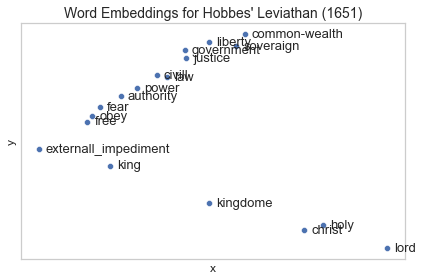

In [71]:
# Seaborn globals
sns.set(rc={'figure.figsize':(10,6)})
sns.set_theme(style="whitegrid")
word_plot = sns.scatterplot(data=lev_df,x='x',y='y')
word_plot.grid(False)
word_plot.set_xticks([])
word_plot.set_yticks([])
word_plot.set_title("Word Embeddings for Hobbes' Leviathan (1651)", fontdict={'size':14})
label_points(lev_df.x, lev_df.y, lev_df.token, plt.gca(), x_offset=0.1, adjustments=label_adjustments_lev)
plt.tight_layout()
fig_output_fpath = os.path.join(fig_path, 'leviathan_embeddings.svg')
plt.savefig(fig_output_fpath)

In [72]:
lev_df

,token,x,y
0,authority,2.404587,3.981800
1,christ,4.982621,-7.800631
2,civill,2.910420,5.770978
3,common-wealth,4.146952,9.405495
4,externall_impediment,1.248701,-0.720720
5,fear,2.110340,2.996876
6,free,1.934815,1.712980
7,government,3.302604,8.032058
8,holy,5.239315,-7.335640
9,justice,3.321737,7.348581


In [73]:
lev_df['x'].min(), lev_df['x'].max()

(1.2487009, 6.1493263)

In [74]:
class PointData:
    def __init__(self, x, y, label):
        self.x = x
        self.y = y
        self.label = label

    def __str__(self):
        escaped_label = self.label.replace("_","\\_")
        #quoted_label = "\"" + escaped_label + "\""
        styled_label = "\\entpgf{" + escaped_label + "}"
        return f"({self.x}, {self.y})[{styled_label}]"

tikz_start = """
	\\begin{tikzpicture}
		\\begin{axis}[axis lines=center,
			xmin=!pyxmin!, xmax=!pyxmax!,
			ymin=!pyymin!-!pyycap!, ymax=!pyymax!+!pyycap!,
			xtick={!pyxmin!,!pyxmax!},ytick={!pyymin!,!pyymax!},
			xlabel=$x$,ylabel=$y$,
			x label style={anchor=west},
			y label style={anchor=south},
			width=\\textwidth
			]
			\\addplot+[only marks,point meta=explicit symbolic, nodes near coords] coordinates
			{
"""
tikz_end = """
    };
    \\end{axis}
	\\end{tikzpicture}
"""

tikz_header = """
\\usepackage{amsmath}
\\usepackage{amssymb}
\\usepackage{mathtools}
\\usepackage{fullpage}
\\usepackage[T1]{fontenc}
\\usepackage{lmodern}
\\usepackage{tikz}
\\usetikzlibrary{calc,intersections,through,backgrounds}
\\usetikzlibrary{bayesnet}
\\usepackage{tikzscale}
\\usepackage{tkz-euclide}
\\usepackage{tcolorbox}
\\tcbuselibrary{skins,breakable}
% pgfplots
\\usepackage{pgfplots}
\\pgfplotsset{compat=1.8}
% For entities in pgfplots
\\newcommand{\entpgf}[1]{\\texttt{#1}}
"""

def custom_latex_export(df, self_contained=False):
    pd_list = []
    for row_index, row in df.iterrows():
        cur_pd = PointData(row['x'], row['y'], row['token'])
        pd_list.append(str(cur_pd))
    pd_str = "\n".join(pd_list)
    pyxmin = math.floor(df['x'].min())
    pyxmax = math.ceil(df['x'].max())
    pyymin = math.floor(df['y'].min())
    pyymax = math.ceil(df['y'].max())
    tex_start_lims = tikz_start
    tex_start_lims = tex_start_lims.replace("!pyxmin!",str(pyxmin)).replace("!pyxmax!",str(pyxmax))
    tex_start_lims = tex_start_lims.replace("!pyymin!",str(pyymin)).replace("!pyymax!",str(pyymax))
    # Extend the axis a bit past the min/max
    pyyrange = pyymax - pyymin
    pyycap = 0.02 * pyyrange
    tex_start_lims = tex_start_lims.replace("!pyycap!", str(pyycap))
    return_str = tex_start_lims + pd_str + tikz_end
    if self_contained:
        # Wrap it in a document
        doc_start = "\\documentclass{article}\n" + tikz_header + "\n\\begin{document}\n"
        doc_end = "\n\\end{document}"
        wrap_str = doc_start + return_str + doc_end
        return wrap_str
    return return_str
# For previewing
#tex_str = custom_latex_export(lev_df, self_contained=True)
#pyperclip.copy(tex_str)
# For exporting
tex_str = custom_latex_export(lev_df)
pyperclip.copy(tex_str)
tex_output_fpath = os.path.join(fig_path, "hobbes_embeddings.tex")
with open(tex_output_fpath, 'w', encoding='utf-8') as outfile:
    outfile.write(tex_str)

### And now get the word-context matrix for these terms

In [75]:
lev_sent_tokens_combined = []
for cur_sent_tokens in clean_sent_tokens_lev:
    lev_sent_tokens_combined.extend(cur_sent_tokens)

In [76]:
lev_ngrams = list(compute_ngrams(lev_sent_tokens_combined, 21))
#len(lev_ngrams)
lev_kw_pair_counts = {kw_pair: 0 for kw_pair in kw_pairs}
#print(lev_kw_pair_counts)
for cur_ngram in tqdm(lev_ngrams):
    center_word = cur_ngram[10]
    if center_word not in keywords:
        continue
    # If we're here, we know the center word is a keyword
    for cur_context_token in cur_ngram:
        if cur_context_token in keywords:
            # Get the pair in alpha order
            kw_pair_tuple = (center_word, cur_context_token)
            alpha_tuple = tuple(sorted(kw_pair_tuple))
            lev_kw_pair_counts[alpha_tuple] += 1

100%|██████████| 94314/94314 [00:00<00:00, 1088643.80it/s]


In [77]:
lev_kw_pair_counts

{('authority', 'authority'): 425,
 ('authority', 'christ'): 54,
 ('authority', 'civill'): 68,
 ('authority', 'common-wealth'): 134,
 ('authority', 'externall_impediment'): 0,
 ('authority', 'fear'): 2,
 ('authority', 'free'): 0,
 ('authority', 'government'): 12,
 ('authority', 'holy'): 18,
 ('authority', 'justice'): 4,
 ('authority', 'king'): 98,
 ('authority', 'kingdome'): 38,
 ('authority', 'law'): 256,
 ('authority', 'liberty'): 14,
 ('authority', 'lord'): 6,
 ('authority', 'obey'): 34,
 ('authority', 'power'): 140,
 ('authority', 'soveraign'): 224,
 ('christ', 'authority'): 0,
 ('christ', 'christ'): 727,
 ('christ', 'civill'): 18,
 ('christ', 'common-wealth'): 12,
 ('christ', 'externall_impediment'): 0,
 ('christ', 'fear'): 2,
 ('christ', 'free'): 8,
 ('christ', 'government'): 4,
 ('christ', 'holy'): 50,
 ('christ', 'justice'): 0,
 ('christ', 'king'): 130,
 ('christ', 'kingdome'): 130,
 ('christ', 'law'): 74,
 ('christ', 'liberty'): 4,
 ('christ', 'lord'): 40,
 ('christ', 'obey'): 

In [78]:
#list(itertools.combinations_with_replacement(cur_ngram,2))

In [79]:
# And now restrict to just the kw pairs
kw_pair_rows = [[k[0],k[1],v] for k, v in lev_kw_pair_counts.items() if k in kw_pairs]

In [80]:
kw_pair_df = pd.DataFrame(kw_pair_rows, columns=['word1','word2','co_freq'])
kw_pair_df.sort_values(by=['word1','word2'], inplace=True)
kw_pair_df.set_index('word1', inplace=True)
kw_pair_df

,word2,co_freq
word1,,
authority,authority,425
authority,christ,54
authority,civill,68
authority,common-wealth,134
authority,externall_impediment,0
...,...,...
soveraign,liberty,0
soveraign,lord,0
soveraign,obey,0


In [81]:
kw_grid_df = kw_pair_df.pivot(columns=['word2'])
#kw_grid_df.fillna(0.0, inplace=True)
kw_grid_df.columns = [c[1] for c in kw_grid_df.columns]
kw_grid_df.columns.name = None
kw_grid_df.index.name = None
# Need to make it symmetric
#first_index = kw_grid_df.index[0]
#kw_grid_df.insert(0,first_index,np.nan)
# Finally, we can reflect across the diagonal
num_rows = len(kw_grid_df.index)
for i in range(num_rows):
    for j in range(i, num_rows):
        kw_grid_df.iloc[j,i] = kw_grid_df.iloc[i,j]
kw_grid_df

,authority,christ,civill,common-wealth,externall_impediment,fear,free,government,holy,justice,king,kingdome,law,liberty,lord,obey,power,soveraign
authority,425,54,68,134,0,2,0,12,18,4,98,38,256,14,6,34,140,224
christ,54,727,18,12,0,2,8,4,50,0,130,130,74,4,40,42,80,32
civill,68,18,414,150,0,24,8,76,10,20,92,40,562,26,6,66,236,278
common-wealth,134,12,150,598,0,18,8,36,0,38,34,22,444,48,8,62,216,320
externall_impediment,0,0,0,0,3,0,2,0,0,0,0,0,0,12,0,0,2,0
fear,2,2,24,18,0,259,2,4,2,12,2,2,42,30,6,26,98,28
free,0,8,8,8,2,2,91,4,0,0,0,2,36,46,0,4,16,4
government,12,4,76,36,0,4,4,204,0,4,40,16,54,12,2,16,58,60
holy,18,50,10,0,0,2,0,0,250,2,28,24,14,2,14,2,20,20
justice,4,0,20,38,0,12,0,4,2,143,28,4,100,0,2,8,36,38


In [82]:
# Sort by the diagonal entry
diag_entries = []
for cur_col in kw_grid_df.columns:
    cur_diag = kw_grid_df.loc[cur_col, cur_col]
    diag_entries.append((cur_col, cur_diag))
diag_sorted_counts = sorted(diag_entries, key=lambda x: x[1], reverse=True)
diag_sorted_tokens = [c[0] for c in diag_sorted_counts]
diag_sorted_tokens

['law',
 'power',
 'soveraign',
 'christ',
 'king',
 'common-wealth',
 'kingdome',
 'authority',
 'civill',
 'obey',
 'fear',
 'holy',
 'liberty',
 'government',
 'lord',
 'justice',
 'free',
 'externall_impediment']

In [83]:
final_tokens = diag_sorted_tokens[:4] + diag_sorted_tokens[-1:]
final_tokens

['law', 'power', 'soveraign', 'christ', 'externall_impediment']

In [84]:
final_grid_df = kw_grid_df[final_tokens].loc[final_tokens].astype(int).astype(str).copy()

In [85]:
final_grid_df["\\cdots"] = "\\cdots"

In [86]:
orig_cols = list(final_grid_df.columns)
new_col_order = orig_cols[:-2] + ["\\cdots"] + orig_cols[-2:-1]
final_grid_df = final_grid_df[new_col_order].copy()
final_grid_df.loc["\\vdots",:] = "\\vdots"

In [87]:
final_grid_df

,law,power,soveraign,christ,\cdots,externall_impediment
law,2257,376,560,74,\cdots,0
power,376,1071,624,80,\cdots,2
soveraign,560,624,983,32,\cdots,0
christ,74,80,32,727,\cdots,0
externall_impediment,0,2,0,0,\cdots,3
\vdots,\vdots,\vdots,\vdots,\vdots,\vdots,\vdots


In [88]:
orig_rows = list(final_grid_df.index)
new_row_order = orig_rows[:-2] + ["\\vdots"] + orig_rows[-2:-1]
final_grid_df = final_grid_df.loc[new_row_order,:].copy()

In [89]:
final_grid_df.iloc[-2,-2] = "\\ddots"

In [90]:
#final_grid_df.fillna(0.0, inplace=True)
for cur_col in final_grid_df.columns:
    if "cdots" in cur_col:
        continue
    rename_map = {cur_col: "\\texttt{" + cur_col + "}"}
    final_grid_df.rename(columns=rename_map, inplace=True)
    final_grid_df.rename(index=rename_map, inplace=True)
final_grid_df

,\texttt{law},\texttt{power},\texttt{soveraign},\texttt{christ},\cdots,\texttt{externall_impediment}
\texttt{law},2257,376,560,74,\cdots,0
\texttt{power},376,1071,624,80,\cdots,2
\texttt{soveraign},560,624,983,32,\cdots,0
\texttt{christ},74,80,32,727,\cdots,0
\vdots,\vdots,\vdots,\vdots,\vdots,\ddots,\vdots
\texttt{externall_impediment},0,2,0,0,\cdots,3


In [91]:
# In TeX
print(final_grid_df.style.to_latex())

\begin{tabular}{lllllll}
 & \texttt{law} & \texttt{power} & \texttt{soveraign} & \texttt{christ} & \cdots & \texttt{externall_impediment} \\
\texttt{law} & 2257 & 376 & 560 & 74 & \cdots & 0 \\
\texttt{power} & 376 & 1071 & 624 & 80 & \cdots & 2 \\
\texttt{soveraign} & 560 & 624 & 983 & 32 & \cdots & 0 \\
\texttt{christ} & 74 & 80 & 32 & 727 & \cdots & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
\texttt{externall_impediment} & 0 & 2 & 0 & 0 & \cdots & 3 \\
\end{tabular}



In [92]:
# And now the embeddings
final_emb_df = lev_df[lev_df['token'].isin(final_tokens)].copy()
final_emb_df.set_index('token', inplace=True)
final_emb_df = final_emb_df.loc[final_tokens,].copy()
round_coord = lambda x: "{:.2f}".format(x)
final_rounded_df = final_emb_df.copy()
final_rounded_df['x'] = final_rounded_df['x'].apply(round_coord)
final_rounded_df['y'] = final_rounded_df['y'].apply(round_coord)
final_rounded_df

,x,y
token,,
law,3.05,5.63
power,2.64,4.67
soveraign,4.03,8.32
christ,4.98,-7.80
externall_impediment,1.25,-0.72


In [93]:
for cur_index in final_rounded_df.index:
    new_index = "\\texttt{" + str(cur_index) + "}"
    final_rounded_df.rename(index={cur_index:new_index}, inplace=True)

In [94]:
final_rounded_df.loc["\\vdots"] = "\\vdots"

In [95]:
orig_row_order = list(final_rounded_df.index)
new_row_order = orig_row_order[:-2] + ["\\vdots"] + orig_row_order[-2:-1]
final_rounded_df = final_rounded_df.loc[new_row_order,:].copy()

In [96]:
print(final_rounded_df.style.to_latex())

\begin{tabular}{lll}
 & x & y \\
token &  &  \\
\texttt{law} & 3.05 & 5.63 \\
\texttt{power} & 2.64 & 4.67 \\
\texttt{soveraign} & 4.03 & 8.32 \\
\texttt{christ} & 4.98 & -7.80 \\
\vdots & \vdots & \vdots \\
\texttt{externall_impediment} & 1.25 & -0.72 \\
\end{tabular}





### Part 2: De Cive

In [242]:
text_dc = load_texts(['de_cive'])
len(text_dc)

542963

In [243]:
clean_text_dc = text_dc.lower()
sents_dc = nltk.tokenize.sent_tokenize(clean_text_dc, "english")
sent_tokens_dc = [nltk.tokenize.word_tokenize(sent) for sent in sents_dc]
clean_sent_tokens_dc = [preprocess_tokens(sent_tokens) for sent_tokens in sent_tokens_dc]

alwayes externall
externall court
belongs externall
externall obey
promise externall
externall signes
lets externall
externall 
 externall
externall agent
profession externall
externall 


In [244]:
dc_model = Word2Vec(sentences=clean_sent_tokens_dc, vector_size=2, window=global_window,
                        min_count=1, workers=4, epochs=global_epochs)

dc_model.save("w2v_dc.model")

In [245]:
dc_df = get_embedding_df(dc_model)

In [246]:
label_adjustments_dc = {}

FileNotFoundError: [Errno 2] No such file or directory: '../tex/ch0/figs/dc_embeddings.svg'

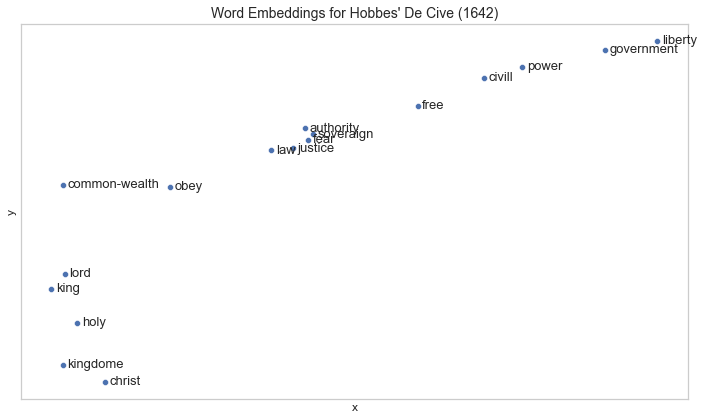

In [247]:
dc_plot = sns.scatterplot(data=dc_df,x='x',y='y')
dc_plot.grid(False)
dc_plot.set_xticks([])
dc_plot.set_yticks([])
dc_plot.set_title("Word Embeddings for Hobbes' De Cive (1642)", fontdict={'size':14})
label_points(dc_df.x, dc_df.y, dc_df.token, plt.gca(), x_offset=0.05, adjustments=label_adjustments_dc)
plt.tight_layout()
svg_fpath = '../tex/ch0/figs/dc_embeddings.svg'
plt.savefig(svg_fpath)

### Part 3: Elements

In [ ]:
text_elem = load_texts(['elements'])
len(text_elem)

In [ ]:
clean_text_elem = text_elem.lower()
sents_elem = nltk.tokenize.sent_tokenize(clean_text_elem, "english")
sent_tokens_elem = [nltk.tokenize.word_tokenize(sent) for sent in sents_elem]
clean_sent_tokens_elem = [preprocess_tokens(sent_tokens) for sent_tokens in sent_tokens_elem]

In [ ]:
elem_model = Word2Vec(sentences=clean_sent_tokens_elem, vector_size=2, window=global_window,
                        min_count=1, workers=4, epochs=global_epochs)

elem_model.save("w2v_elem.model")

In [ ]:
elem_df = get_embedding_df(elem_model)

In [ ]:
label_adjustments_elem = {}

In [248]:
elem_plot = sns.scatterplot(data=elem_df,x='x',y='y')
elem_plot.grid(False)
elem_plot.set_xticks([])
elem_plot.set_yticks([])
elem_plot.set_title("Word Embeddings for Hobbes' Elements (1645)", fontdict={'size':14})
label_points(elem_df.x, elem_df.y, elem_df.token, plt.gca(), x_offset=0.05, adjustments=label_adjustments_elem)
plt.tight_layout()
svg_fpath = '../tex/ch0/figs/elem_embeddings.svg'
plt.savefig(svg_fpath)

NameError: name 'elem_df' is not defined

### Part 3: Leviathan, Behemoth, De Cive

In [249]:
text_hobbes = load_texts()
len(text_hobbes)

2501361

In [250]:
clean_text_hobbes = text_hobbes.lower()
sents_hobbes = nltk.tokenize.sent_tokenize(clean_text_hobbes, "english")
sent_tokens_hobbes = [nltk.tokenize.word_tokenize(sent) for sent in sents_hobbes]
clean_sent_tokens_hobbes = [preprocess_tokens(sent_tokens) for sent_tokens in sent_tokens_hobbes]

alwayes externall
externall court
belongs externall
externall obey
promise externall
externall signes
lets externall
externall 
 externall
externall agent
profession externall
externall 
 externall
externall 
action externall
externall objects
 externall
externall objects
jews externall
externall performance
religion externall
externall worship
 externall
externall action
internall externall
externall righteousness
 externall
externall body
 externall
externall things
receive externall
externall bodies
action externall
externall objects
action externall
externall objects
helps externall
externall 
 externall
externall substances
absence externall
externall impediment
Joining ('externall', 'impediment')
mean externall
externall impediment
Joining ('externall', 'impediment')
opposition externall
externall body
without externall
externall impediment
Joining ('externall', 'impediment')
 externall
externall accidents
caused externall
externall obstacle
 externall
externall violence
 externa

In [251]:
get_token_counts(clean_sent_tokens_hobbes)

[('man', 4085),
 ('law', 2222),
 ('god', 2067),
 ('one', 1670),
 ('power', 1506),
 ('therefore', 1350),
 ('king', 1333),
 ('may', 1292),
 ('also', 1221),
 ('hath', 1088),
 ('right', 1074),
 ('shall', 1071),
 ('nature', 923),
 ('every', 891),
 ('subject', 885),
 ('say', 852),
 ('another', 811),
 ('people', 753),
 ('yet', 739),
 ('time', 736),
 ('upon', 735),
 ('christ', 722),
 ('things', 703),
 ('soveraign', 697),
 ('without', 686),
 ('made', 671),
 ('first', 663),
 ('reason', 653),
 ('called', 652),
 ('authority', 609),
 ('make', 604),
 ('onely', 583),
 ('many', 578),
 ('obey', 577),
 ('though', 574),
 ('good', 561),
 ('thing', 558),
 ('civill', 520),
 ('words', 513),
 ('place', 506),
 ('parliament', 505),
 ('either', 501),
 ('done', 499),
 ('must', 496),
 ('said', 495),
 ('great', 491),
 ('would', 488),
 ('doe', 479),
 ('part', 475),
 ('much', 469),
 ('church', 465),
 ('word', 465),
 ('nothing', 431),
 ('government', 430),
 ('common-wealth', 427),
 ('kingdome', 409),
 ('naturall', 398

In [252]:
hobbes_model = Word2Vec(sentences=clean_sent_tokens_hobbes, vector_size=2, window=global_window,
                        min_count=1, workers=4, epochs=global_epochs)

hobbes_model.save("w2v_hobbes.model")

In [253]:
hobbes_df = get_embedding_df(hobbes_model)

In [254]:

point_adjustments_hobbes = {
    #'obligation': np.array([0,0.2]),
    #'common-wealth': np.array([0,0.1]),
    #'liberty': np.array([0,0.4]),
    'government': [0,-0.25],
    'justice': [0.0,0.2],
    #'law': np.array([0,-0.2]),
    #'civill': np.array([0.2,0.0]),
    #'soveraign': np.array([0,-0.1]),
    #'holy': np.array([0,0.0]),
    'lord': [-0.1,0.2],
    'holy': [0.05,0.00],
    'king': [0.0,0.1],
    'kingdome': [0.00,-0.15],
    'christ': [0.00,-0.1],
    #'liberty': [0.00,0.5],
    'free': [0.00,0.5],
}
# And adjust the vals accordingly
hobbes_df.set_index('token', inplace=True)
for adj_word, adj_shift in point_adjustments_hobbes.items():
    hobbes_df.loc[adj_word] = hobbes_df.loc[adj_word] + np.array(adj_shift)
hobbes_df.reset_index(inplace=True)
label_adjustments_hobbes = {
}

And plot

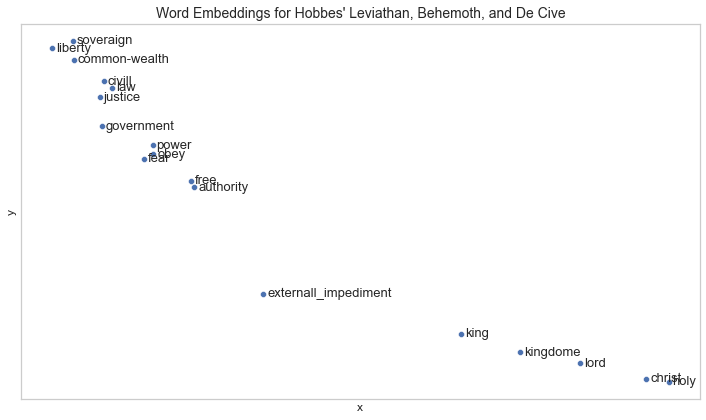

In [256]:
hobbes_plot = sns.scatterplot(data=hobbes_df,x='x',y='y')
hobbes_plot.grid(False)
hobbes_plot.set_xticks([])
hobbes_plot.set_yticks([])
hobbes_plot.set_title("Word Embeddings for Hobbes' Leviathan, Behemoth, and De Cive", fontdict={'size':14})
label_points(hobbes_df.x, hobbes_df.y, hobbes_df.token, plt.gca(), x_offset=0.05, adjustments=label_adjustments_hobbes)
plt.tight_layout()
svg_fpath = os.path.join(fig_path, 'hobbes-embeddings.svg')
plt.savefig(svg_fpath)

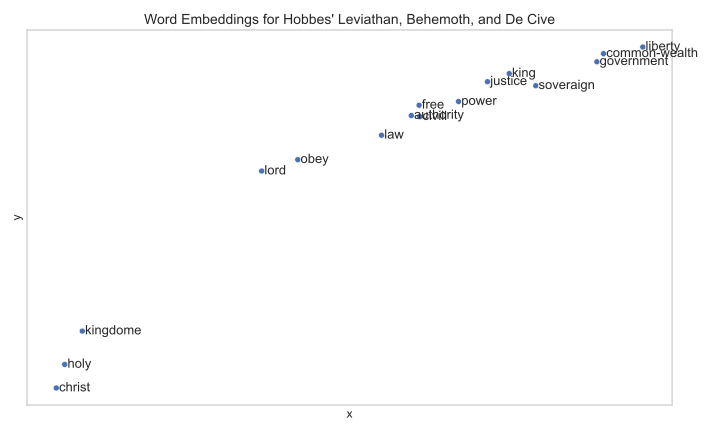

In [1553]:
from IPython.display import SVG
SVG(svg_fpath)